# Feature Analysis of Skin Lesion Images

This notebook analyzes different feature extraction methods used in our skin lesion classification system:
1. Feature A - Asymmetry
2. Feature B - Border Properties
3. Feature C - Color Properties
4. Hair Coverage Analysis

## Import Required Libraries and Load Data

In [22]:
import sys
import os
# Add parent directory to Python path to import util modules
sys.path.append(os.path.abspath('..'))

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import cv2
from sklearn.preprocessing import StandardScaler

# Import our feature extraction utilities
from util.feature_A import mean_asymmetry
from util.feature_B import B_compactness
from util.feature_C import get_color_vector
from util.image_util import enhance_color_hsv_clahe

# Load the dataset
data = pd.read_csv('dataset.csv')

# Load the feature dataset
feature_data = pd.read_csv('result/feature_dataset_extended.csv')

print("Datasets loaded:")
print(f"Main dataset shape: {data.shape}")
print(f"Feature dataset shape: {feature_data.shape}")

Datasets loaded:
Main dataset shape: (2298, 26)
Feature dataset shape: (1804, 15)


## 1a. Feature Distribution Analysis

Let's analyze the distribution of each feature and their relationship with cancer diagnosis

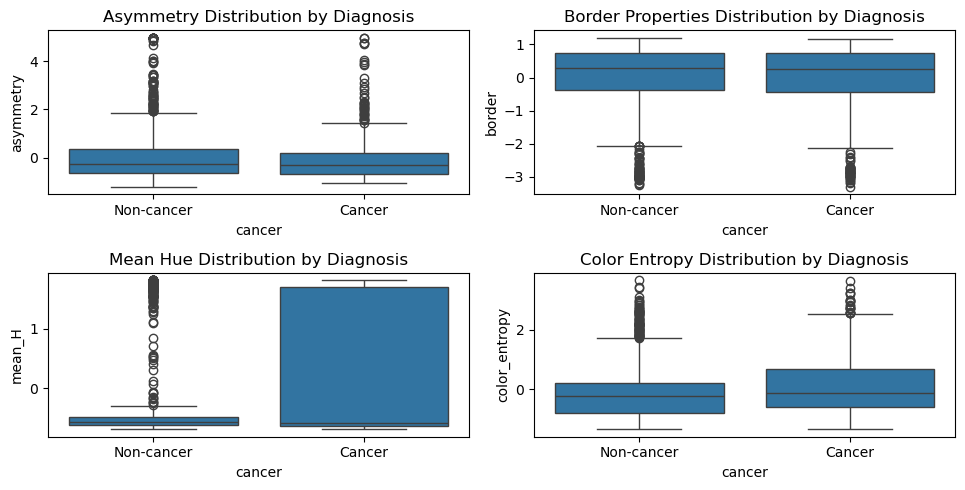

In [35]:
# Standardize numeric columns to make features comparable 
# feature_cols = feature_data.select_dtypes(include=[np.number]).columns.tolist()
# exclude_cols = ['cancer']  
# cols_to_standardize = [col for col in feature_cols if col not in exclude_cols]

# scaler = StandardScaler()
# feature_data[cols_to_standardize] = scaler.fit_transform(feature_data[cols_to_standardize])

plt.figure(figsize=(10, 5))
# plt.suptitle('Standardized Feature Distributions')

# Create subplots for each feature
plt.subplot(2, 2, 1)
sns.boxplot(x='cancer', y='asymmetry', data=feature_data)
plt.title('Asymmetry Distribution by Diagnosis')
plt.xticks([0, 1], ['Non-cancer', 'Cancer'])

plt.subplot(2, 2, 2)
sns.boxplot(x='cancer', y='border', data=feature_data)
plt.title('Border Properties Distribution by Diagnosis')
plt.xticks([0, 1], ['Non-cancer', 'Cancer'])

plt.subplot(2, 2, 3)
sns.boxplot(x='cancer', y='mean_H', data=feature_data)
plt.title('Mean Hue Distribution by Diagnosis')
plt.xticks([0, 1], ['Non-cancer', 'Cancer'])

plt.subplot(2, 2, 4)
sns.boxplot(x='cancer', y='color_entropy', data=feature_data)
plt.title('Color Entropy Distribution by Diagnosis')
plt.xticks([0, 1], ['Non-cancer', 'Cancer'])

plt.tight_layout()
plt.show()

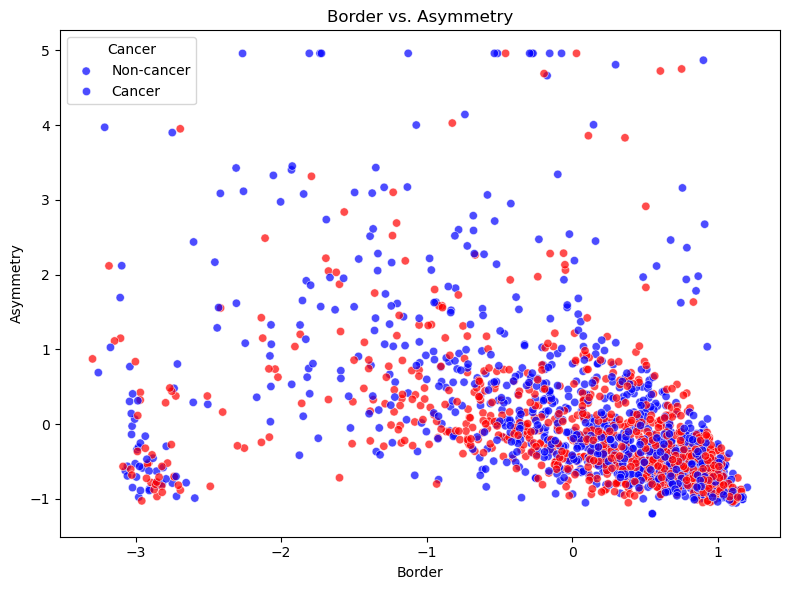

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=feature_data,
    x='border',
    y='asymmetry',
    hue='cancer',
    palette={0: 'blue', 1: 'red'},
    alpha=0.7
)
plt.title('Border vs. Asymmetry')
plt.xlabel('Border')
plt.ylabel('Asymmetry')
plt.legend(title='Cancer', labels=['Non-cancer', 'Cancer'])
plt.tight_layout()
plt.show()

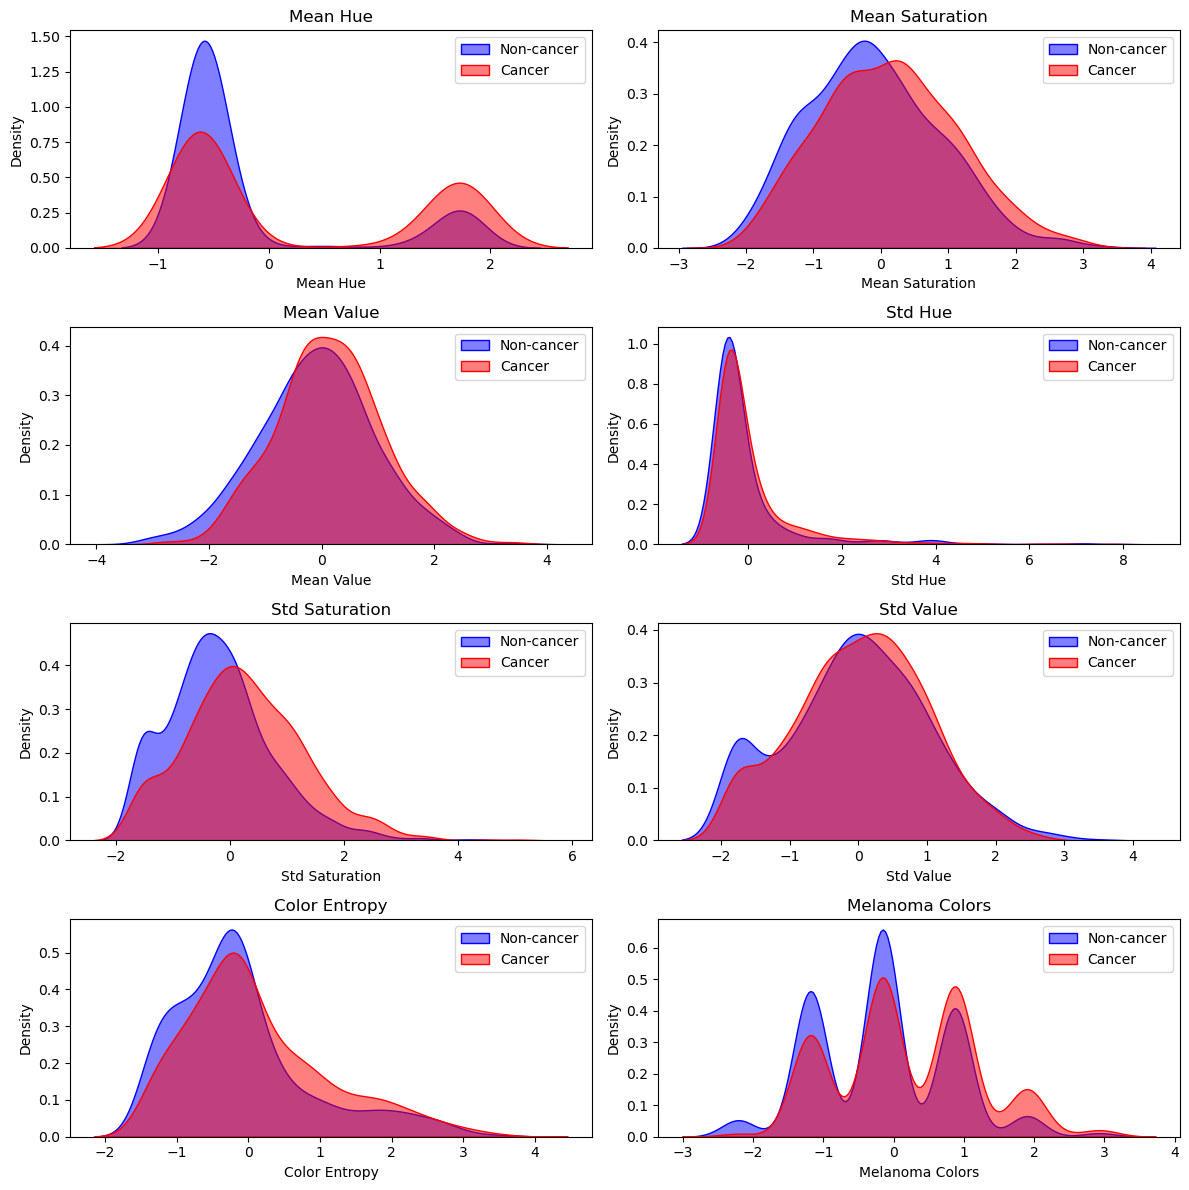

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    ('mean_H', 'Mean Hue'),
    ('mean_S', 'Mean Saturation'),
    ('mean_V', 'Mean Value'),
    ('std_H', 'Std Hue'),
    ('std_S', 'Std Saturation'),
    ('std_V', 'Std Value'),
    ('color_entropy', 'Color Entropy'),
    ('melanoma_colors', 'Melanoma Colors')
]

n_plots = len(features)
n_cols = 2
n_rows = (n_plots + 1) // n_cols

plt.figure(figsize=(12, n_rows * 3))

for i, (col, label) in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.kdeplot(
        data=feature_data[feature_data['cancer'] == 0],
        x=col, fill=True, label='Non-cancer', color='blue', alpha=0.5
    )
    sns.kdeplot(
        data=feature_data[feature_data['cancer'] == 1],
        x=col, fill=True, label='Cancer', color='red', alpha=0.5
    )
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

## 1b. Feature Consistency

Let's analyze the distribution of each feature and their relationship with cancer diagnosis

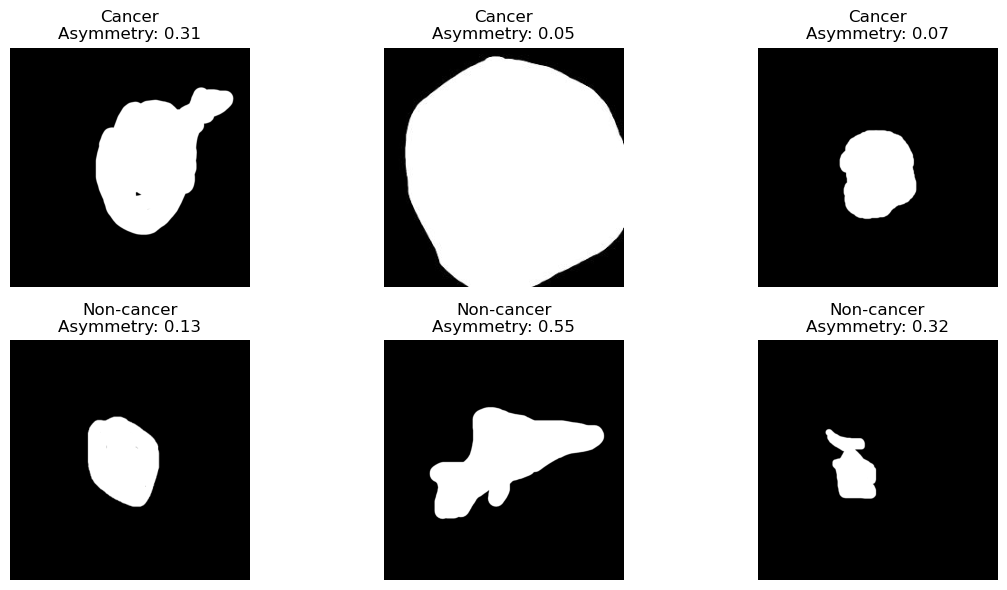

In [25]:
import random

random.seed()

cancerous = feature_data[feature_data['cancer'] == 1]
non_cancerous = feature_data[feature_data['cancer'] == 0]

# Randomly sample 3 from each
sample_cancer = cancerous.sample(3)
sample_non_cancer = non_cancerous.sample(3)

# Combine for plotting
samples = pd.concat([sample_cancer, sample_non_cancer]).reset_index(drop=True)

plt.figure(figsize=(12, 6))
for i, row in samples.iterrows():
    img_id = row['img_id']
    border_val = row['asymmetry'] #playing around with different features
    mask_path = f'data/lesion_masks/{img_id.replace(".png", "_mask.png")}'
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.squeeze()

    plt.subplot(2, 3, i+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"{'Cancer' if row['cancer']==1 else 'Non-cancer'}\nAsymmetry: {border_val:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Feature Correlation Analysis

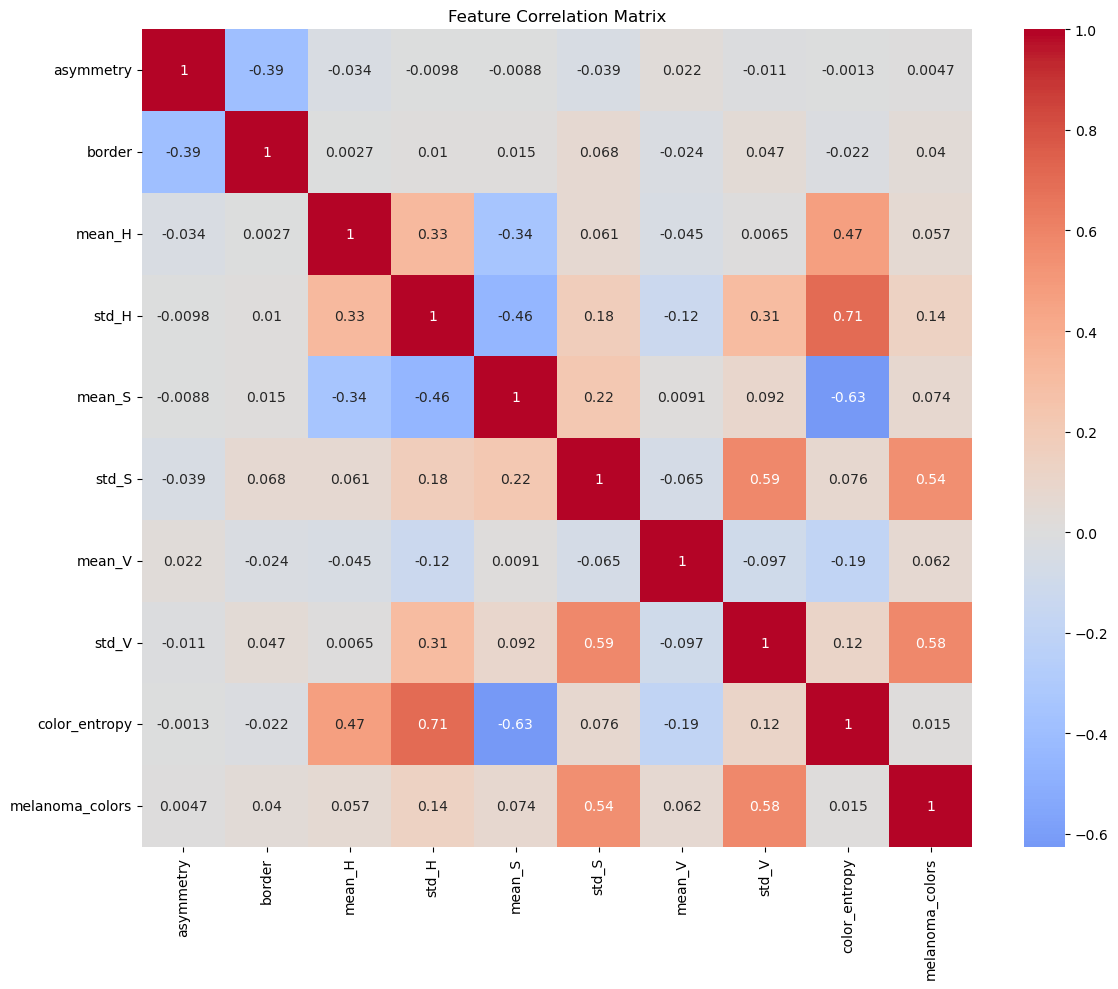

In [37]:
# Select relevant features for correlation analysis
features_for_correlation = ['asymmetry', 'border', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V', 'color_entropy', 'melanoma_colors']

# Create correlation matrix
correlation_matrix = feature_data[features_for_correlation].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 2b. Finding the best features

Best 3 features for class separability: ['std_S', 'mean_H', 'melanoma_colors']


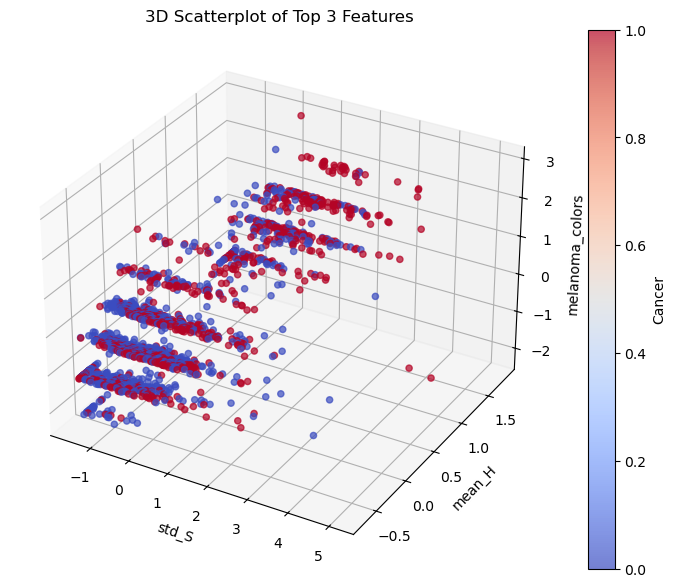

In [38]:
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


candidate_features = [
    'asymmetry', 'border', 'mean_H', 'std_H', 'mean_S', 'std_S', 'mean_V', 'std_V', 'color_entropy', 'melanoma_colors'
]


t_stats = {}
for feature in candidate_features:
    group1 = feature_data[feature_data['cancer'] == 1][feature]
    group0 = feature_data[feature_data['cancer'] == 0][feature]
    t_stat, _ = stats.ttest_ind(group1, group0, nan_policy='omit')
    t_stats[feature] = abs(t_stat)


best_features = sorted(t_stats, key=t_stats.get, reverse=True)[:3]
print("Best 3 features for class separability:", best_features)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    feature_data[best_features[0]],
    feature_data[best_features[1]],
    feature_data[best_features[2]],
    c=feature_data['cancer'],
    cmap='coolwarm',
    alpha=0.7
)

ax.set_xlabel(best_features[0])
ax.set_ylabel(best_features[1])
ax.set_zlabel(best_features[2])
ax.set_title('3D Scatterplot of Top 3 Features')
plt.colorbar(scatter, ax=ax, label='Cancer')
plt.show()

## 3. Enhanced Hair Coverage Analysis

This section provides a detailed analysis of hair coverage with:
1. Visualization of the original image
2. Hair detection mask
3. Hair coverage percentage (normalized to lesion area)
4. Comparison across different hair density levels

Analyzing images with varying hair coverage...



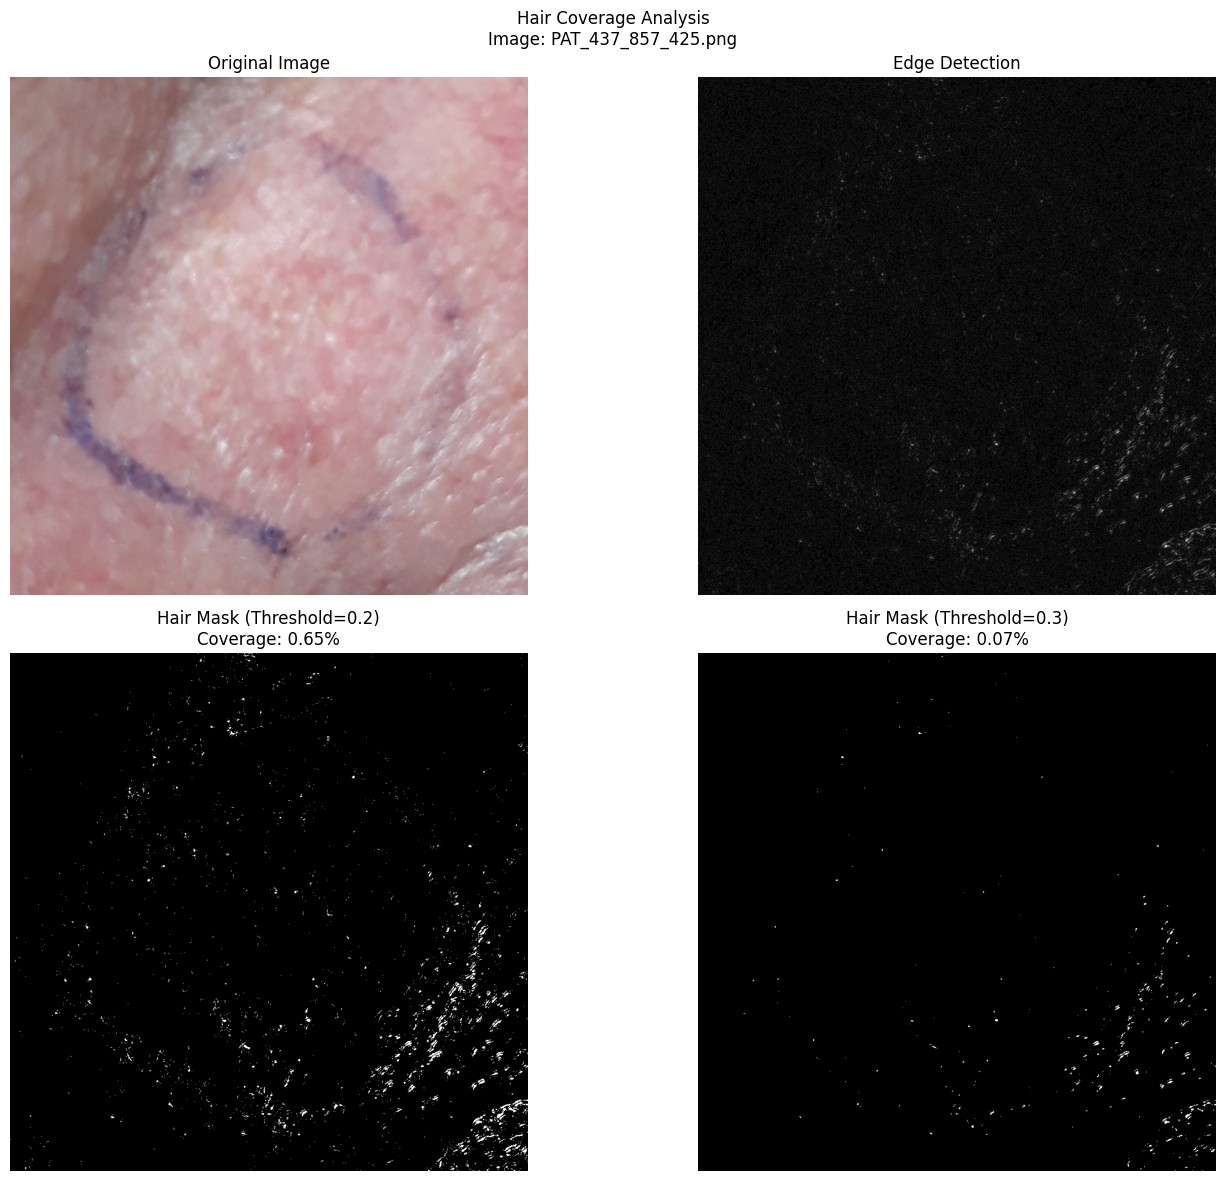

Image PAT_437_857_425.png:
Hair coverage at different thresholds: [np.float64(0.65), np.float64(0.07), np.float64(0.03)]%



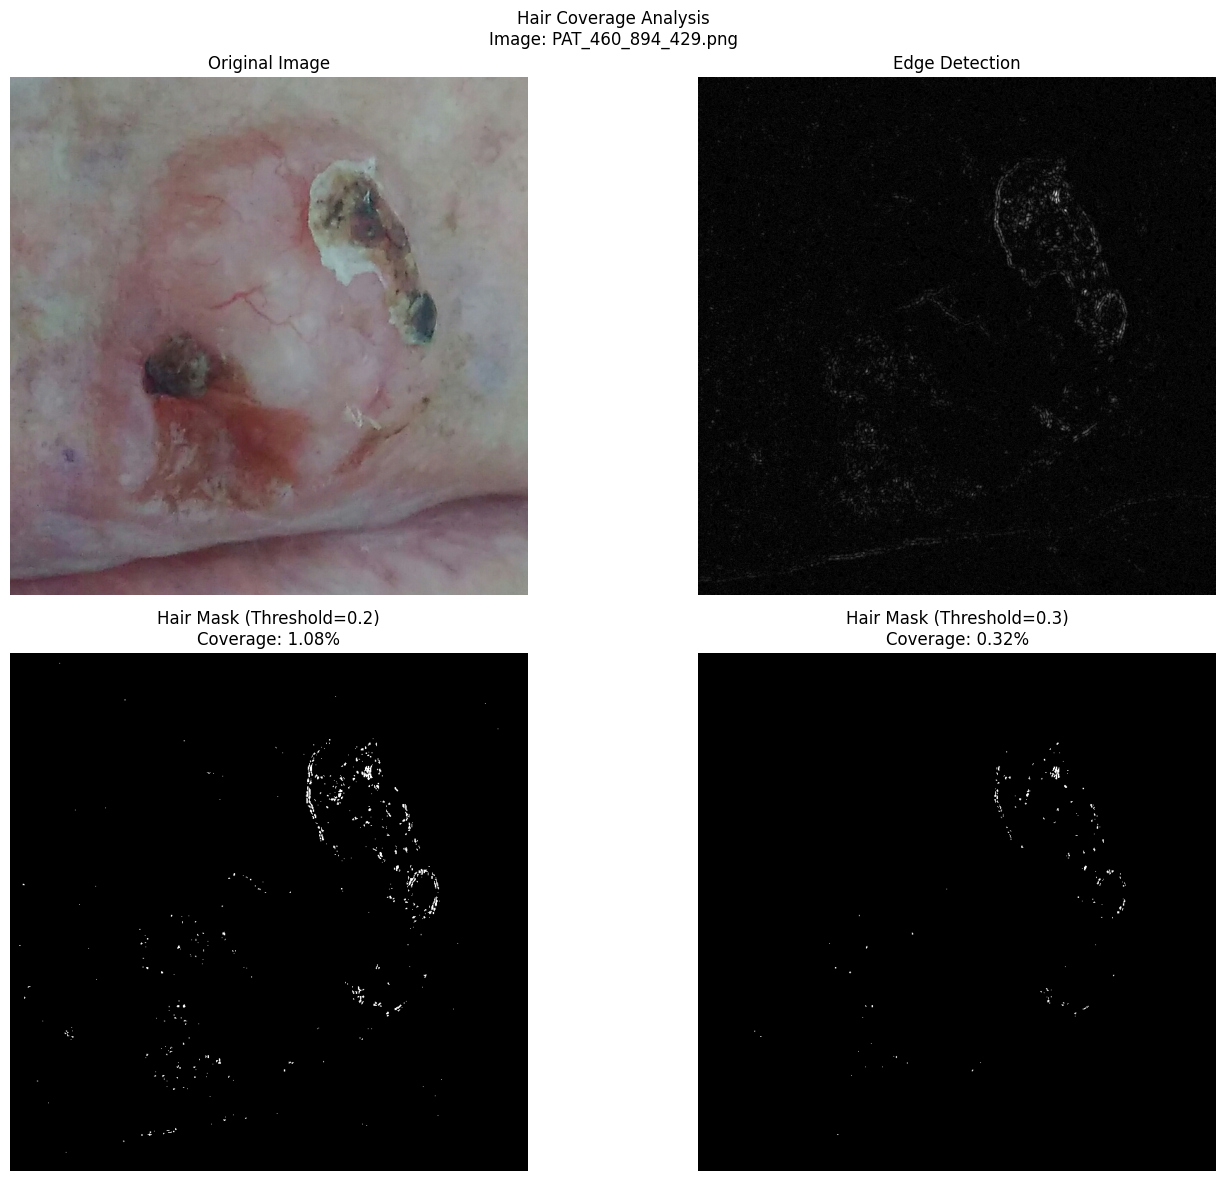

Image PAT_460_894_429.png:
Hair coverage at different thresholds: [np.float64(1.08), np.float64(0.32), np.float64(0.09)]%



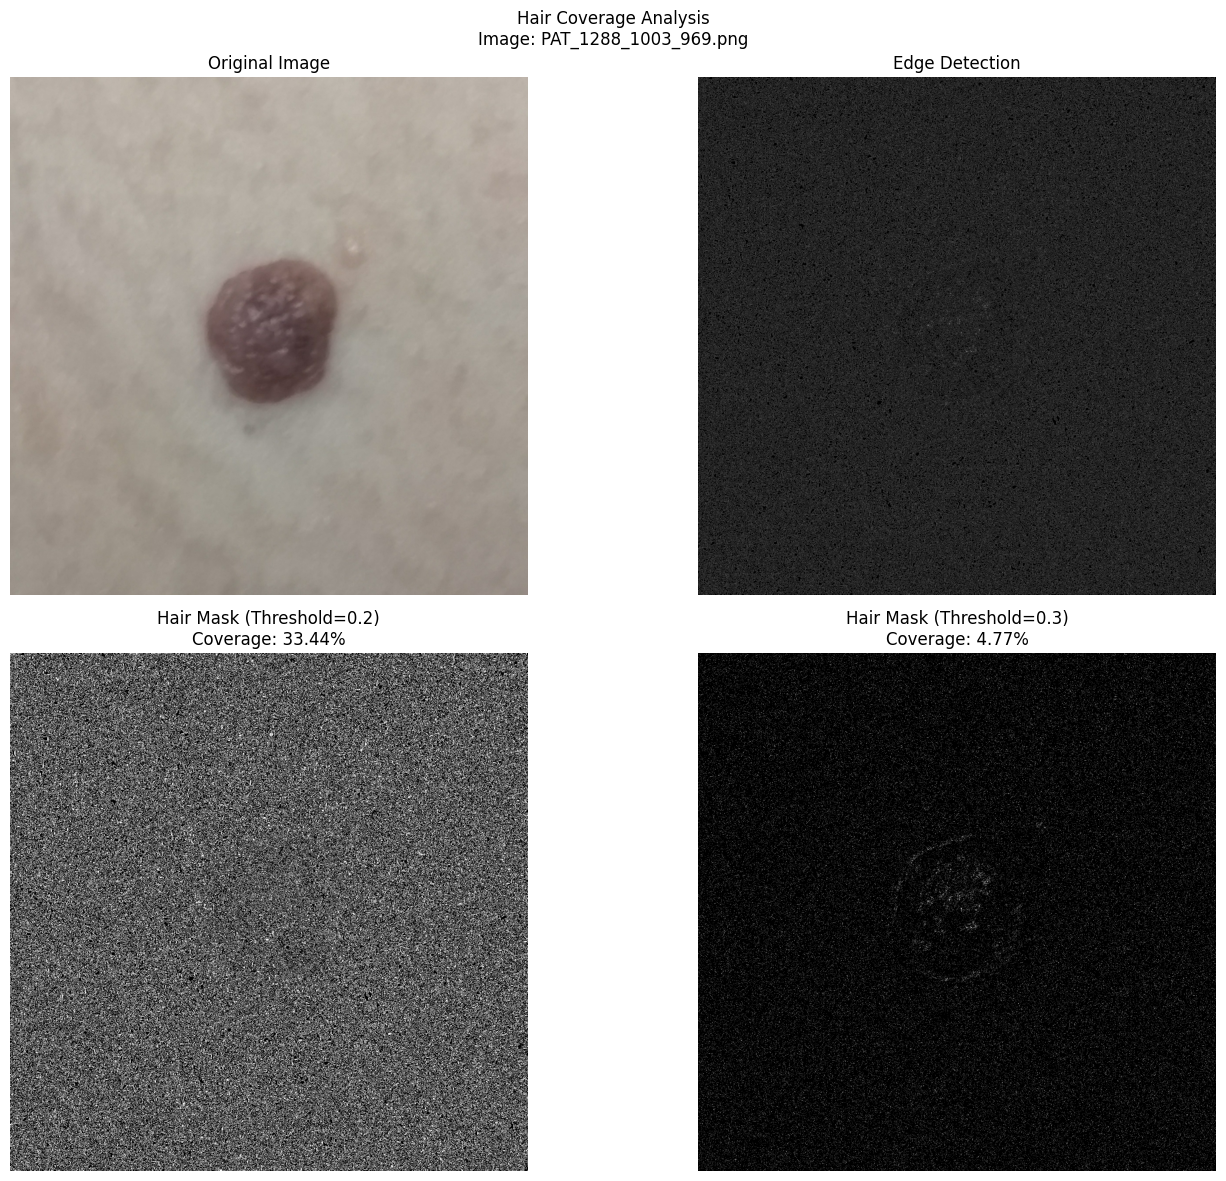

Image PAT_1288_1003_969.png:
Hair coverage at different thresholds: [np.float64(33.44), np.float64(4.77), np.float64(0.66)]%



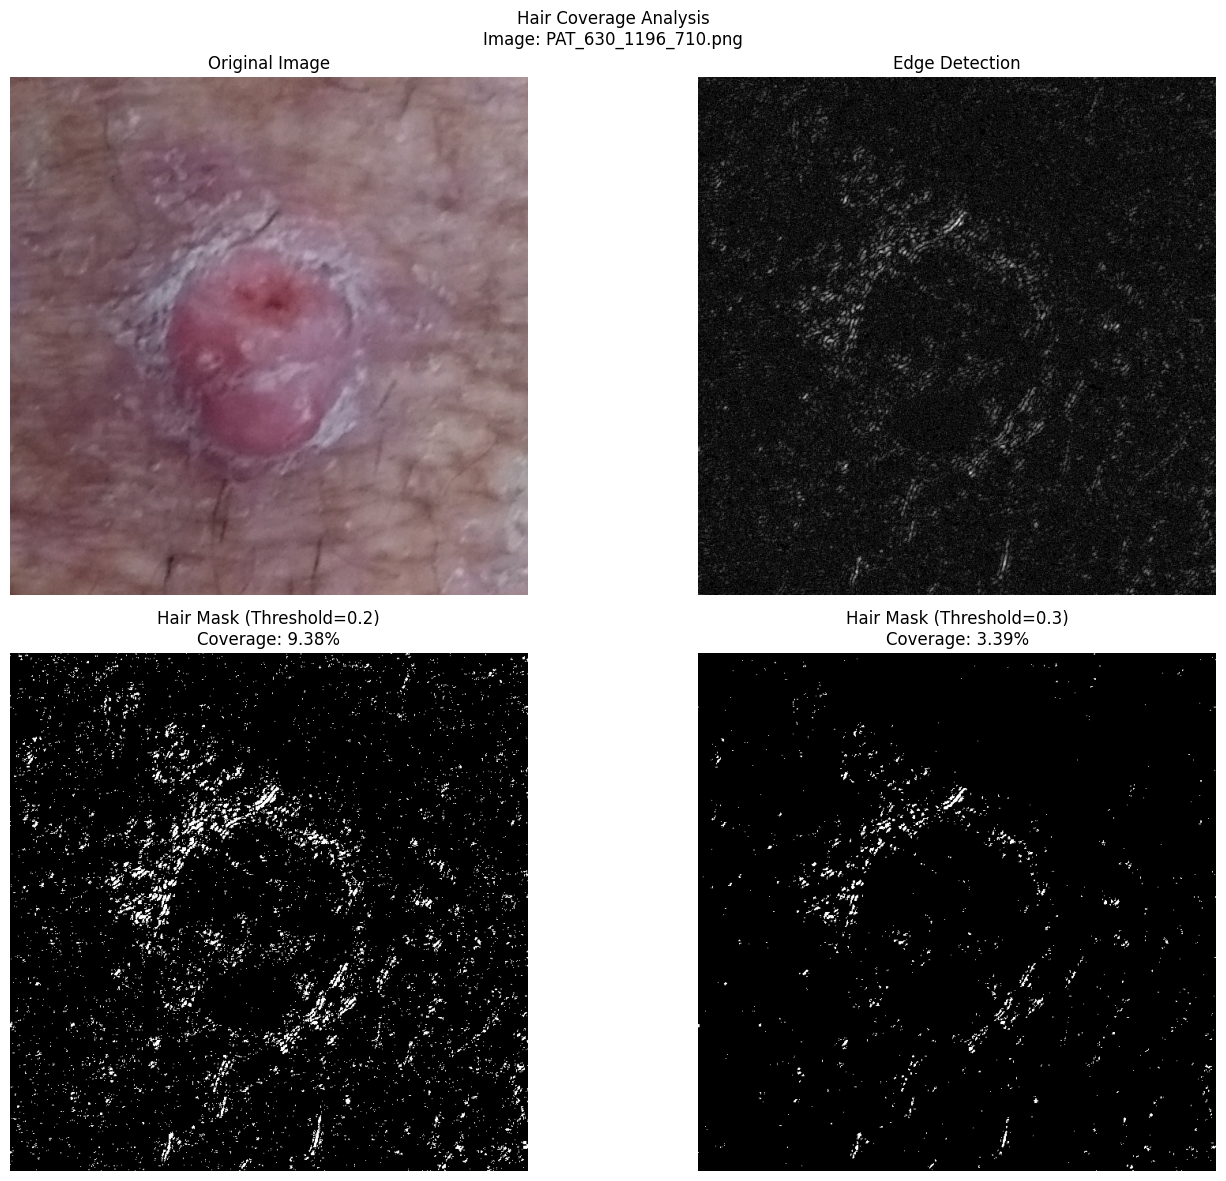

Image PAT_630_1196_710.png:
Hair coverage at different thresholds: [np.float64(9.38), np.float64(3.39), np.float64(1.21)]%



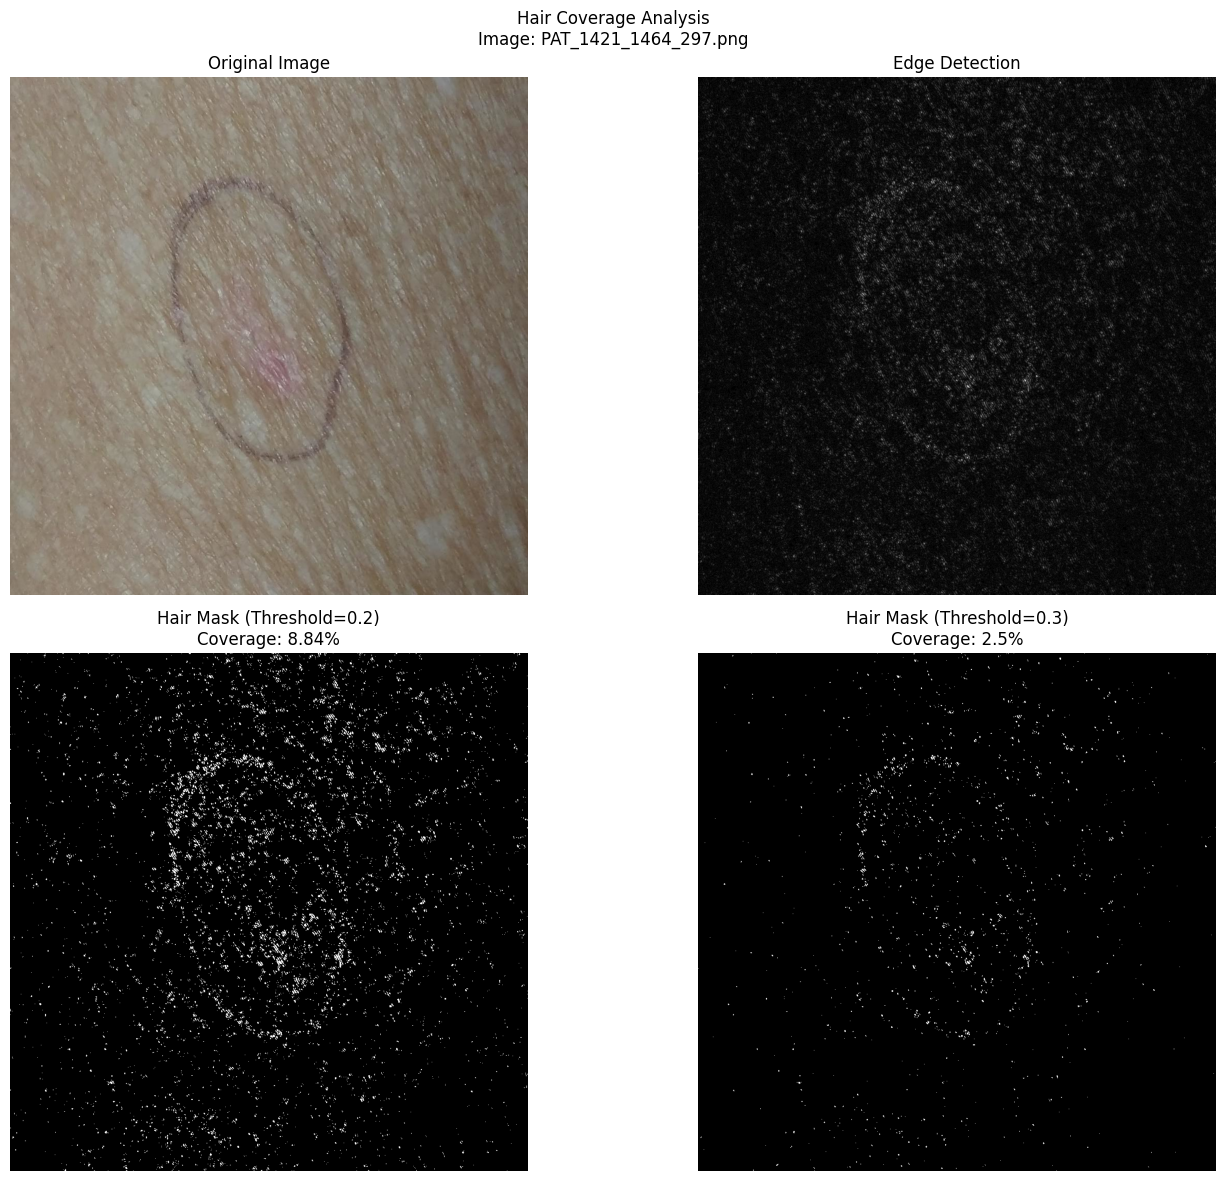

Image PAT_1421_1464_297.png:
Hair coverage at different thresholds: [np.float64(8.84), np.float64(2.5), np.float64(0.82)]%



In [7]:
def analyze_hair_coverage(image_path, mask_path=None):
    # Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Create or load mask
    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    else:
        mask = np.ones_like(img_gray)
    
    # Enhanced hair detection
    blurred = cv2.GaussianBlur(img_gray, (7,7), 0)
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F, ksize=3)
    laplacian_abs = np.absolute(laplacian)
    laplacian_norm = cv2.normalize(laplacian_abs, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Create hair mask with different thresholds
    thresholds = [0.2, 0.3, 0.4]  # Different sensitivity levels
    hair_masks = []
    coverages = []
    
    for thresh in thresholds:
        threshold_value = int(thresh * 255)
        hair_mask = (laplacian_norm > threshold_value).astype(np.uint8)
        
        # Calculate coverage within lesion area only
        lesion_area = np.sum(mask > 0)
        hair_on_lesion = np.logical_and(hair_mask > 0, mask > 0)
        coverage = np.sum(hair_on_lesion) / lesion_area if lesion_area > 0 else 0
        
        hair_masks.append(hair_mask)
        coverages.append(round(coverage * 100, 2))  # Convert to percentage
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Hair Coverage Analysis\nImage: {os.path.basename(image_path)}')
    
    # Original image
    axes[0,0].imshow(img)
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    # Edge detection result
    axes[0,1].imshow(laplacian_norm, cmap='gray')
    axes[0,1].set_title('Edge Detection')
    axes[0,1].axis('off')
    
    # Hair masks with different thresholds
    for i, (mask, coverage, thresh) in enumerate(zip(hair_masks, coverages, thresholds)):
        if i < 2:  # Show only two thresholds to fit in our grid
            axes[1,i].imshow(mask * 255, cmap='gray')
            axes[1,i].set_title(f'Hair Mask (Threshold={thresh})\nCoverage: {coverage}%')
            axes[1,i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return coverages

# Analyze a set of sample images with different hair densities
sample_images = feature_data.sort_values('hair_coverage').iloc[::len(feature_data)//5]['img_id'].head()
print("Analyzing images with varying hair coverage...\n")

for img_id in sample_images:
    img_path = f'../data/imgs/{img_id}'
    mask_path = f'../data/lesion_masks/{img_id.replace(".png", "_mask.png")}' if os.path.exists(f'../data/lesion_masks/{img_id.replace(".png", "_mask.png")}') else None
    coverages = analyze_hair_coverage(img_path, mask_path)
    print(f"Image {img_id}:")
    print(f"Hair coverage at different thresholds: {coverages}%\n")

## 4. Parameter Sensitivity Analysis

Analyze how different parameters affect feature extraction

In [8]:
def analyze_color_parameters(sample_image_path):
    # Read sample image
    img = cv2.imread(sample_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = np.ones(img.shape[:2], dtype=np.uint8)  # Simple mask for testing
    
    # Test different parameters
    downsizing_factors = [0.2, 0.4, 0.6, 0.8]
    n_segments_values = [30, 50, 70, 90]
    
    results = []
    for factor in downsizing_factors:
        for segments in n_segments_values:
            color_vector = get_color_vector(img, mask, downsizing_factor=factor, n_segments=segments)
            results.append({
                'downsizing_factor': factor,
                'n_segments': segments,
                'mean_H': color_vector['mean_H'],
                'color_entropy': color_vector['color_entropy']
            })
    
    return pd.DataFrame(results)

# Analyze parameters for a sample image
sample_image = image_paths[0]
param_results = analyze_color_parameters(sample_image)

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=param_results, x='downsizing_factor', y='mean_H', hue='n_segments')
plt.title('Impact of Parameters on Mean Hue')

plt.subplot(1, 2, 2)
sns.lineplot(data=param_results, x='downsizing_factor', y='color_entropy', hue='n_segments')
plt.title('Impact of Parameters on Color Entropy')

plt.tight_layout()
plt.show()

NameError: name 'image_paths' is not defined

## 5. Statistical Tests

Perform statistical analysis to evaluate feature significance

In [8]:
def perform_statistical_tests(feature_data):
    features = ['asymmetry', 'border', 'mean_H', 'color_entropy']
    results = []
    
    for feature in features:
        # Split data by cancer/non-cancer
        cancer_group = feature_data[feature_data['cancer'] == 1][feature]
        non_cancer_group = feature_data[feature_data['cancer'] == 0][feature]
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(cancer_group, non_cancer_group)
        
        results.append({
            'feature': feature,
            't_statistic': t_stat,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)

# Perform statistical tests
statistical_results = perform_statistical_tests(feature_data)
print("Statistical Test Results:")
print(statistical_results)

Statistical Test Results:
         feature  t_statistic       p_value
0      asymmetry    -0.325706  7.446959e-01
1         border    -2.008578  4.477361e-02
2         mean_H     7.492166  1.195005e-13
3  color_entropy     2.734921  6.318254e-03


## 6. Feature Relationships in 3D Space

Visualize relationships between multiple features in 3D space

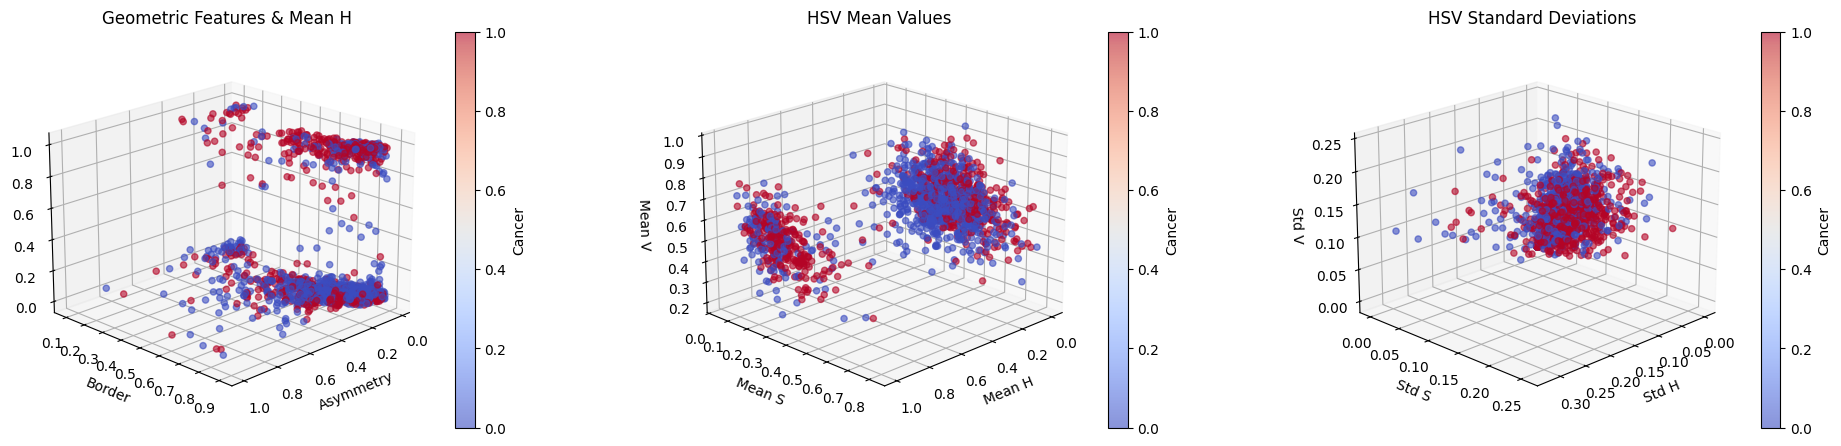

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plots with different feature combinations
fig = plt.figure(figsize=(20, 5))

# Plot 1: Geometric features
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(
    feature_data['asymmetry'],
    feature_data['border'],
    feature_data['mean_H'],
    c=feature_data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax1.set_xlabel('Asymmetry')
ax1.set_ylabel('Border')
ax1.set_zlabel('Mean H')
ax1.set_title('Geometric Features & Mean H')
plt.colorbar(scatter1, ax=ax1, label='Cancer')

# Plot 2: Color features - HSV means
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(
    feature_data['mean_H'],
    feature_data['mean_S'],
    feature_data['mean_V'],
    c=feature_data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax2.set_xlabel('Mean H')
ax2.set_ylabel('Mean S')
ax2.set_zlabel('Mean V')
ax2.set_title('HSV Mean Values')
plt.colorbar(scatter2, ax=ax2, label='Cancer')

# Plot 3: Color features - HSV std deviations
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(
    feature_data['std_H'],
    feature_data['std_S'],
    feature_data['std_V'],
    c=feature_data['cancer'],
    cmap='coolwarm',
    alpha=0.6
)
ax3.set_xlabel('Std H')
ax3.set_ylabel('Std S')
ax3.set_zlabel('Std V')
ax3.set_title('HSV Standard Deviations')
plt.colorbar(scatter3, ax=ax3, label='Cancer')

# Add rotation for better visualization
for ax in [ax1, ax2, ax3]:
    ax.view_init(elev=20, azim=45)

plt.tight_layout(pad=3.0)
plt.show()

## 7. Patient Distribution Analysis

Analyze how features are distributed across different patients

Total number of unique patients: 911
Average images per patient: 1.54
Max images per patient: 9
Min images per patient: 1


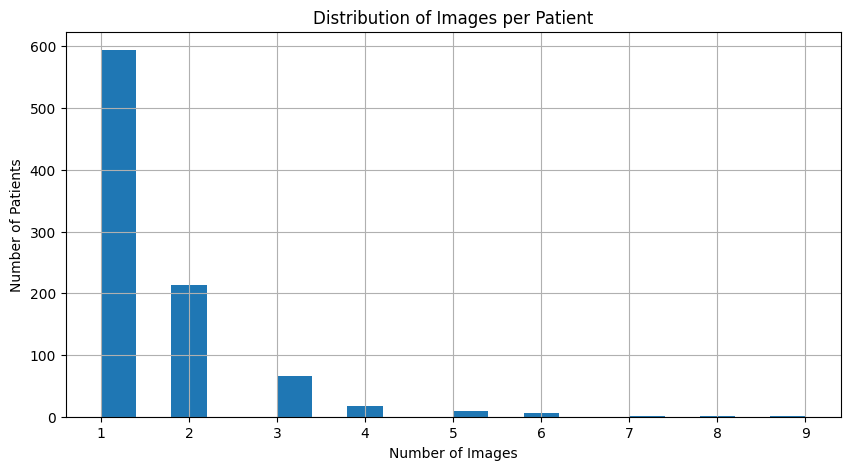

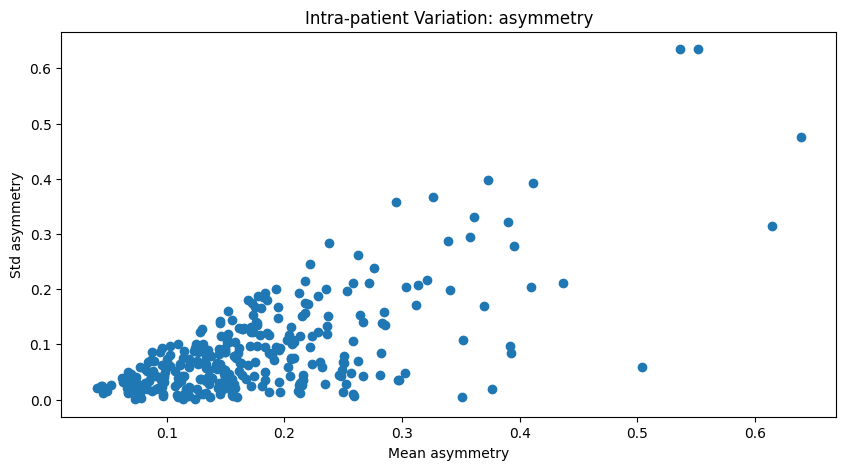

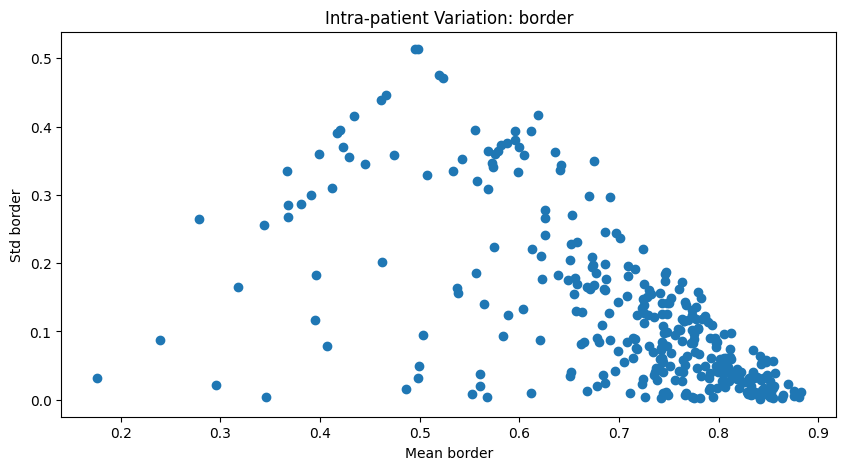

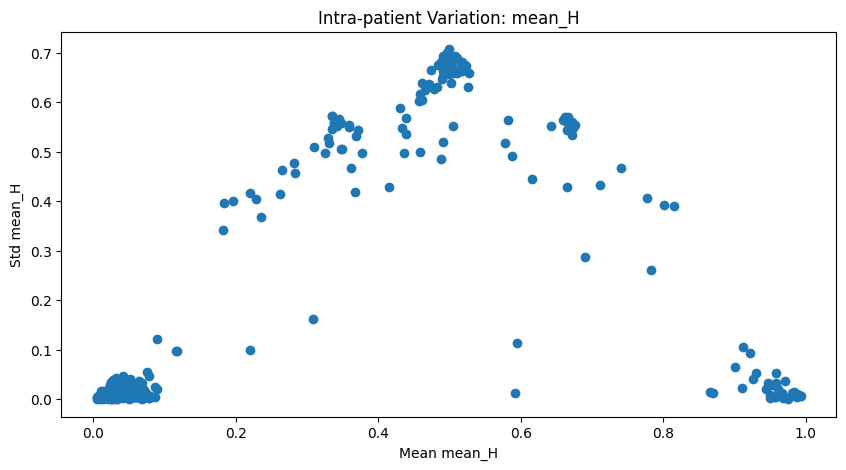

In [10]:
# Analyze patient distribution
patient_counts = feature_data['patient_id'].value_counts()

print(f"Total number of unique patients: {len(patient_counts)}")
print(f"Average images per patient: {patient_counts.mean():.2f}")
print(f"Max images per patient: {patient_counts.max()}")
print(f"Min images per patient: {patient_counts.min()}")

# Show distribution of number of images per patient
plt.figure(figsize=(10, 5))
patient_counts.hist(bins=20)
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.show()

# Analyze feature variation within patients
def calculate_intrapatient_variation(feature_data, feature):
    return feature_data.groupby('patient_id')[feature].agg(['mean', 'std']).dropna()

features_to_analyze = ['asymmetry', 'border', 'mean_H']
for feature in features_to_analyze:
    variation = calculate_intrapatient_variation(feature_data, feature)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(variation['mean'], variation['std'])
    plt.title(f'Intra-patient Variation: {feature}')
    plt.xlabel(f'Mean {feature}')
    plt.ylabel(f'Std {feature}')
    plt.show()

## 8. Hair Coverage Impact Analysis

Analyze how hair coverage affects other features

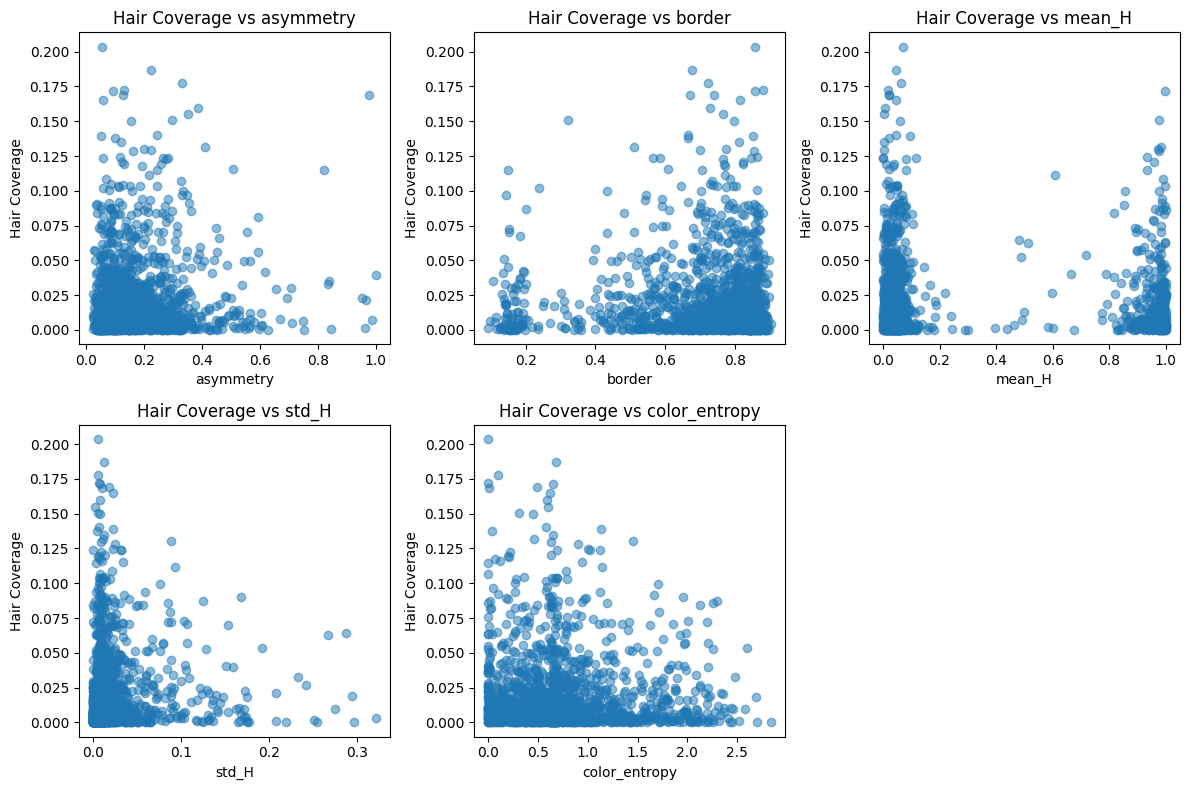


Correlations with Hair Coverage:
asymmetry: 0.054
border: 0.027
mean_H: -0.019
std_H: 0.011
color_entropy: -0.074


In [11]:
# Calculate correlations between hair coverage and other features
features_vs_hair = ['asymmetry', 'border', 'mean_H', 'std_H', 'color_entropy']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_vs_hair):
    plt.subplot(2, 3, i+1)
    plt.scatter(feature_data[feature], feature_data['hair_coverage'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Hair Coverage')
    plt.title(f'Hair Coverage vs {feature}')

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
correlations = {feature: feature_data['hair_coverage'].corr(feature_data[feature]) 
               for feature in features_vs_hair}
print("\nCorrelations with Hair Coverage:")
for feature, corr in correlations.items():
    print(f"{feature}: {corr:.3f}")